<a href="https://colab.research.google.com/github/laventura/pytorch_projects/blob/main/05_NLP_CharRNN_Generate_Names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CharRNN - Generator

In the first tutorial we used a RNN to classify names into their language of origin. This time we’ll turn around and generate names from languages.

```

> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun

```

We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

In [1]:
## Download dataset
import requests
import zipfile
import os

def download_and_unzip_data(url, target_dir='.'):
    # Create the target directory if it doesn't exist
    os.makedirs(target_dir, exist_ok=True)

    # Download the file
    print(f"Downloading URL: {url}")
    response = requests.get(url)
    if response.status_code == 200:
        # Get the filename from the URL
        filename = url.split('/')[-1]
        filepath = os.path.join(target_dir, filename)

        # Save the file
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")

        # Unzip the file
        with zipfile.ZipFile(filepath, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"Extracted contents to {target_dir}")

        # Remove the zip file
        os.remove(filepath)
        print(f"Removed {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

In [2]:
dataset_url = "https://download.pytorch.org/tutorial/data.zip"
download_and_unzip_data(dataset_url)

Downloaded data.zip
Extracted contents to .
Removed data.zip


In [4]:
from io import open
import glob
import os

import unicodedata
import string

def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Dutch', 'Korean', 'Scottish', 'German', 'Spanish', 'Vietnamese', 'Chinese', 'Arabic', 'Russian', 'Polish', 'Greek', 'French', 'Italian', 'Portuguese', 'Japanese', 'Czech', 'Irish', 'English']
O'Neal


## Creating an RNN -

Extending previous RNN network, by adding  an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer `o2o` (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

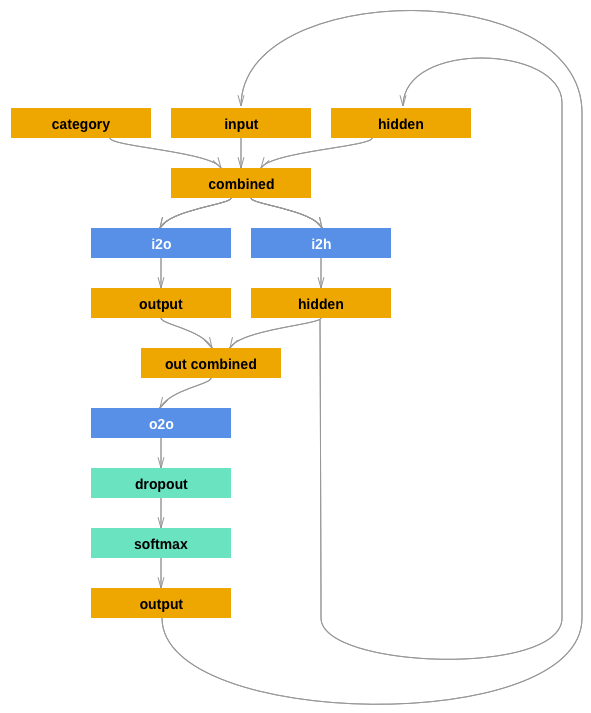

In [5]:
import torch
import torch.nn as nn
import math
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

#### Training

For each timestep (that is, for each letter in a training word) the inputs of the network will be `(category, current letter, hidden state)` and the outputs will be `(next letter, next hidden state)`. So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"ABCD<EOS>"` we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

The category tensor is a one-hot tensor of size `<1 x n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [7]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


In [8]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()  # fetch a random (cat, line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    # convert to (cat_tensor, line_tensor, target_line_tensor)
    return category_tensor, input_line_tensor, target_line_tensor

### Training the network


In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.


In [9]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [10]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100_000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print(f"{timeSince(start)} - {iter:,<10} {iter / n_iters * 100}% - {loss:<.5f})")

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s - 5000       5.0% - 2.86472)
0m 37s - 10000      10.0% - 3.11903)
0m 55s - 15000      15.0% - 2.57539)
1m 15s - 20000      20.0% - 2.30106)
1m 40s - 25000      25.0% - 2.57926)
2m 0s - 30000      30.0% - 3.03622)
2m 18s - 35000      35.0% - 2.32359)
2m 37s - 40000      40.0% - 2.43739)
2m 57s - 45000      45.0% - 1.89270)
3m 15s - 50000      50.0% - 2.63295)
3m 33s - 55000      55.00000000000001% - 3.66257)
3m 52s - 60000      60.0% - 2.04590)
4m 10s - 65000      65.0% - 2.53854)
4m 29s - 70000      70.0% - 1.74268)
4m 47s - 75000      75.0% - 3.42172)
5m 8s - 80000      80.0% - 2.73091)
5m 26s - 85000      85.0% - 2.54221)
5m 44s - 90000      90.0% - 2.44239)
6m 6s - 95000      95.0% - 2.42573)
6m 24s - 100000     100.0% - 2.40745)


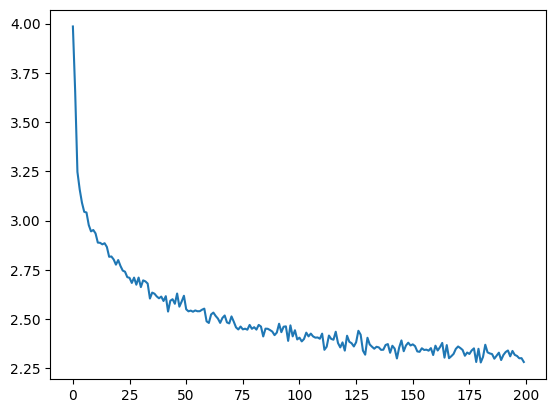

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

    Create tensors for input category, starting letter, and empty hidden state

    Create a string output_name with the starting letter

    Up to a maximum output length,

        Feed the current letter to the network

        Get the next letter from highest output, and next hidden state

        If the letter is EOS, stop here

        If a regular letter, add to output_name and continue

    Return the final name


In [13]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roshino
Uantono
Sanovako
Ganger
Eren
Rouner
Sana
Pana
Allana
Chan
Han
Iun
